This notebook runs all the sites in the submit folder. Each site is run with pyomo and cplex as well as the alternate scheduler. Finally, the results using the forecasts and the scheduler are compared.

In [16]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import time

import seaborn as sns

from __future__ import division

In [17]:
%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})


In [18]:
# Since using the data-driven data for the testing, use their battery class
from battery import Battery

In [19]:
# ==============================================================================
#    THIS CLASS WILL BE IMPLEMENTED BY COMPETITORS
class BatteryContoller(object):

    # callNumbers means we ensure the battery is emptied at the end of the sim even if the forecast says not optimal
    def __init__(self):
        self.callNumber = 0
        self.maxCalls = 960
    
    def propose_state_of_charge(self,
                               site_id,
                               timestamp,
                               battery,
                               actual_previous_load,
                               actual_previous_pv_production,
                               price_buy,
                               price_sell,
                               load_forecast,
                               pv_forecast):
        
        # update the call number
        self.callNumber+=1
        
        ####################################################################################
        # if more than 96 periods left consider full forecast
        #print self.maxCalls-self.callNumber
        if self.maxCalls-self.callNumber>=96:
            loadForecast = load_forecast.iloc[:].values
            pvForecast = pv_forecast.iloc[:].values
            priceBuy = price_buy.iloc[:].values
            priceSell = price_sell.iloc[:].values
        else:
            loadForecast = load_forecast.iloc[:].values[0:(self.maxCalls-self.callNumber)]
            pvForecast = pv_forecast.iloc[:].values[0:(self.maxCalls-self.callNumber)]
            priceBuy = price_buy.iloc[:].values[0:(self.maxCalls-self.callNumber)]
            priceSell = price_sell.iloc[:].values[0:(self.maxCalls-self.callNumber)]

        seriesLength=len(loadForecast)

        ### ------------------------- ESS properties ----------------- ###
        maxSOC = battery.capacity # Units are Wh
        maxChg = battery.charging_power_limit/4. # W
        maxDisChg = battery.discharging_power_limit/4. # W
        etaChg = battery.charging_efficiency
        etaDisChg = battery.discharging_efficiency
        ### ---------------------------------------------------------- ###
        expectedExports = np.zeros((seriesLength)) 
        net = loadForecast-pvForecast
        
        #####################################################################################
        ################## IMPROVEMENT ######################################################
        ########### TO IMPROVE PERFORMANCE WITH FORECAST ADD CORRECTION DUE TO NOISE HERE ###
        # define the noise under threshold, i.e. the margin for error when discharging the batt
        # define the noise over threshold, i.e. the margin for error when charging the batt
        # additionalCaution = 0
        # if net[0]>noiseUnder+additionalCaution:
        #     net[0]=net[0]-(noiseUnder+additionalCaution)
        # elif ((net[0]<(noiseUnder+additionalCaution)) and (net[0]>0)):
        #     net[0] = 0
        # elif ((net[0]<0) and (net[0]>noiseOver-additionalCaution)):
        #     net[0] = 0
        # else:
        #     net[0]=net[0]-noiseOver+additionalCaution  
        
        
        expectedExports[net<0] = -net[net<0]

        # cheat the prices to speed up
        #for j in range(seriesLength):
        #    priceSell[j]+=(j+1)/1000.
        #    priceBuy[j]+=(96-j)/1000.

        # now alter the price in the periods where there is solar available (if req.)
        priceCharge = np.copy(priceBuy)
        priceCharge[net<0] = priceSell[net<0]
        priceDischarge = np.copy(priceSell)
        priceDischarge[net>0] = priceBuy[net>0]

        # get the storage profiles
        SOC = np.zeros((seriesLength))
        deltaSOC = np.zeros((seriesLength))

        # boolean variables for charging/discharging availability
        removeMINH = np.ones((seriesLength))
        removeMAXH = np.ones((seriesLength))
        ##############################################################################################

        demand = np.copy(net)

        initial_charge = battery.current_charge*maxSOC

        ###############################-----------------------------##################################
        # now first, if there is energy stored, sell this and update schedules

        if initial_charge > 0:

            while ((initial_charge>0) and (removeMAXH[0]==True)):

                matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
                matrix[0,:] = np.where(removeMAXH==True)[0]
                matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]    

                indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
                maxh = np.int(matrix[0,indici[0]])
                #print(maxh)
                # discharge at MAXh at the maximum level and update the schedule

                if priceDischarge[maxh]>0.0001:
                    bottleneck = np.zeros((3))
                    bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                    bottleneck[1] = initial_charge
                    ############### cannot output more than local consumption before price change
                    if demand[maxh]>0:
                        bottleneck[2] = demand[maxh]/etaDisChg
                    else:
                        bottleneck[2] = initial_charge
                    #print(bottleneck)
                    actual_bottleneck = np.min(bottleneck) 

                    # action
                    demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                    deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                    SOC[0:maxh] = SOC[0:maxh] + actual_bottleneck

                    # account for small rounding errors
                    if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                        demand[maxh] = 0
                        # update the price
                        priceDischarge[maxh] = priceSell[maxh]


                    # check if at the discharge operation is at capacity
                    if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                        removeMAXH[maxh] = False
                    if deltaSOC[maxh] <= 0 - 0.0001:
                        removeMINH[maxh] = False

                    initial_charge = initial_charge - actual_bottleneck
                else:
                    removeMAXH[maxh] = False

        ###############################-----------------------------##################################

        while np.any(removeMAXH) == True:
            
            ####### SECTION COMMENTED OUT FOR TESTING ##############
            ####### IF NOT RUNNING PERFECT FORESIGHT CASE CAN UNCOMMENT ###
            
            #######exit clauses
            #if ((removeMAXH[0]==False) and (removeMINH[0]==False)):
            #    break
            matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
            matrix[0,:] = np.where(removeMAXH==True)[0]
            matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]

            # find the maximum available price 
            indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
            maxh = np.int(matrix[0,indici[0]])
            #print('Maxh = ', maxh)

            # find the last hour before maxh when storage was full
            r1 = np.where( SOC[0:maxh+1] == maxSOC )[0]
            if r1.size == 0:
                r1 = 0
            else:
                r1 = np.where( SOC[0:maxh+1] == maxSOC )[0][-1]+1
            # find the first hour after maxh when storage is empty
            r2 = np.where( SOC[maxh:] == 0 )[0]
            if r2.size == 0:
                r2 = len(SOC)
            else:
                r2 = np.where( SOC[maxh:] == 0 )[0][0]+maxh-1

            #print('r1 = ', r1)
            #print('r2 = ', r2)

            # find the minh in the time range
            range_price = priceCharge[r1:r2+1]
            range_remove = removeMINH[r1:r2+1]

            # if there is no hour in the range then remove maxh and skip to the end
            if np.any(range_remove) == False:
                removeMAXH[maxh]=False
            else:
                matrix = np.zeros(( 2, len ( np.where(range_remove==True)[0] ) ))
                matrix[0,:] = np.where(range_remove==True)[0]
                matrix[1,:] = range_price[ np.where(range_remove==True)[0] ]

                indici = np.where( matrix[1,:]==np.min( matrix[1,:] ) )[0]
                minh = np.int( matrix[0,indici[0]] + r1 )
                # calculate the marginal cost of operation
                MoC = priceCharge[minh]/(etaChg*etaDisChg)
                #print('Minh = ', minh)

                if ((MoC<priceDischarge[maxh]) and (minh!=maxh)):

                    bottleneck = np.zeros((5))
                    bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                    bottleneck[1] = maxChg*etaChg - deltaSOC[minh]
                    if maxh > minh:
                        bottleneck[2] = maxSOC - np.max(SOC[minh:maxh+1])
                    else:
                        bottleneck[2] = np.min(SOC[maxh:minh+1])

                    ############### cannot output more than local consumption before price change
                    if demand[maxh]>0:
                        bottleneck[3] = demand[maxh]/etaDisChg
                    else:
                        bottleneck[3] = maxSOC

                    ############## cannot charge more than export before price change
                    if expectedExports[minh] > 0:
                        bottleneck[4] = expectedExports[minh]*etaChg
                    else:
                        bottleneck[4] = maxSOC
                    #print(bottleneck)
                    actual_bottleneck = np.min(bottleneck)  

                    # Update the aggregated demand
                    demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                    demand[minh] = demand[minh] + actual_bottleneck/etaChg

                    # update the storage charging schedule
                    expectedExports[minh] = expectedExports[minh] - actual_bottleneck/etaChg
                    deltaSOC[minh] = deltaSOC[minh] + actual_bottleneck
                    deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                    if maxh>minh:
                        SOC[minh:maxh] = SOC[minh:maxh] + actual_bottleneck
                    else:
                        SOC[maxh:minh] = SOC[maxh:minh] - actual_bottleneck

                    # account for small rounding errors
                    if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                        demand[maxh] = 0
                        # update the price
                        priceDischarge[maxh] = priceSell[maxh]
                    if expectedExports[minh] < 0 + 0.0001:
                        expectedExports[minh] = 0
                        # update the price
                        priceCharge[minh] = priceBuy[minh]

                    # check if at the charge or discharge operation is at capacity at either
                    # maxh or minh and remove that hour from the price distribution.
                    if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                        removeMAXH[maxh] = False
                    if deltaSOC[minh] >= maxChg*etaChg-0.0001:
                        removeMINH[minh] = False
                    # only allowing the hour to be selected for either charging or discharging
                    if deltaSOC[maxh] < 0 - 0.0001:
                        removeMINH[maxh] = False
                    if deltaSOC[minh] > 0 + 0.0001:
                        removeMAXH[minh] = False

                else:
                    # if there is no price incentive remove the hours
                    removeMAXH[maxh] = False
                    removeMAXH[minh] = False
        #print(removeMAXH)

        # target state of charge
        target_state = SOC[0]/battery.capacity
        
        return target_state, demand

In [20]:
metadata = pd.read_csv('./metadata.csv', index_col=0)

In [21]:
# initialise a set of results for each: sites scheduled using pyomo/cplex, 
# scheduled using battery_scheduler and scheduled using battery_scheduler and using forecasts
results1= []
scoresOnly1 = []

In [22]:
startTime = time.time()

for site_id, parameters in metadata.iterrows():

    testData = pd.read_csv('./submit/'+str(site_id)+'.csv',parse_dates=['timestamp'],index_col='timestamp')

    for batt_id in [1,2]:

        batt = Battery(capacity=parameters["Battery_"+str(batt_id)+"_Capacity"]*1000,
                   charging_power_limit=parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   discharging_power_limit=-parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   charging_efficiency=parameters["Battery_"+str(batt_id)+"_Charge_Efficiency"],
                   discharging_efficiency=parameters["Battery_"+str(batt_id)+"_Discharge_Efficiency"])


        # get the data at each time period
        for g_id, g_df in testData.groupby('period_id'):

            loadForecast = g_df['actual_consumption'].values
            PVForecast = g_df['actual_pv'].values
            sellPrice = g_df['price_sell_00'].values
            buyPrice = g_df['price_buy_00'].values

            # shorten the arrays so the price and actual line up
            loadForecast = loadForecast[1:]
            PVForecast = PVForecast[1:]
            sellPrice = sellPrice[0:-1]
            buyPrice = buyPrice[0:-1]

            priceDict1 = dict(enumerate(sellPrice))
            priceDict2 = dict(enumerate(buyPrice))

            expectedNet = loadForecast-PVForecast
            # split load into +ve and -ve
            posLoad = np.copy(loadForecast-PVForecast)
            negLoad = np.copy(loadForecast-PVForecast)
            for j,e in enumerate(expectedNet):
                if e>=0:
                    negLoad[j]=0
                else:
                    posLoad[j]=0

            posLoadDict = dict(enumerate(posLoad))
            negLoadDict = dict(enumerate(negLoad))

            # now set up the pyomo model
            # model
            m = en.ConcreteModel()

            # set
            m.Time = en.RangeSet(0, len(loadForecast)-1)

            # variables
            m.SOC = en.Var(m.Time, bounds=(0,batt.capacity), initialize=0) #0
            m.posDeltaSOC = en.Var(m.Time, initialize=0) #1
            m.negDeltaSOC = en.Var(m.Time, initialize=0) #2
            m.posEInGrid = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #3
            m.posEInPV = en.Var(m.Time, bounds=(0,batt.charging_power_limit*(15/60.)), initialize=0) #4
            m.negEOutLocal = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #5
            m.negEOutExport = en.Var(m.Time, bounds=(batt.discharging_power_limit*(15/60.),0), initialize=0) #6
            m.posNetLoad = en.Var(m.Time, initialize=posLoadDict) #7
            m.negNetLoad = en.Var(m.Time, initialize=negLoadDict) #8

            # m.helperVar = en.Var(m.Time, initialize=10.)
            m.Bool_char=en.Var(m.Time,within=en.Boolean) #9
            m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) #10

            # parameters
            m.priceSell = en.Param(m.Time, initialize=priceDict1)
            m.priceBuy = en.Param(m.Time, initialize=priceDict2)
            m.posLoad = en.Param(m.Time, initialize=posLoadDict)
            m.negLoad = en.Param(m.Time, initialize=negLoadDict)

            m.etaChg = en.Param(initialize = batt.charging_efficiency)
            m.etaDisChg = en.Param(initialize = batt.discharging_efficiency)
            m.ChargingLimit = en.Param(initialize = batt.charging_power_limit*(15/60.))
            m.DischargingLimit = en.Param(initialize = batt.discharging_power_limit*(15/60.))

            # objective function
            def Obj_fn(m):
                return sum((m.priceBuy[i]*m.posNetLoad[i]) + (m.priceSell[i]*m.negNetLoad[i]) for i in m.Time)  
            m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)
            # constraints
            def SOC_rule(m,t):
                if t==0:
                    return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
                else:
                    return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
            m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)
            # boolean constraints
            def Bool_char_rule_1(m,i):
                bigM=500000
                return((m.posDeltaSOC[i])>=-bigM*(m.Bool_char[i]))
            m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
            # if battery is charging, charging must be greater than -large
            # if not, charging geq zero
            def Bool_char_rule_2(m,i):
                bigM=500000
                return((m.posDeltaSOC[i])<=0+bigM*(1-m.Bool_dis[i]))
            m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
            # if batt discharging, charging must be leq zero
            # if not, charging leq +large
            def Bool_char_rule_3(m,i):
                bigM=500000
                return((m.negDeltaSOC[i])<=bigM*(m.Bool_dis[i]))
            m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
            # if batt discharge, discharge leq POSITIVE large
            # if not, discharge leq 0
            def Bool_char_rule_4(m,i):
                bigM=500000
                return((m.negDeltaSOC[i])>=0-bigM*(1-m.Bool_char[i]))
            m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
            # if batt charge, discharge geq zero
            # if not, discharge geq -large
            def Batt_char_dis(m,i):
                return (m.Bool_char[i]+m.Bool_dis[i],1)
            m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)
            #ensure charging efficiency is divided
            def pos_E_in_rule(m,i):
                return (m.posEInGrid[i]+m.posEInPV[i]) == m.posDeltaSOC[i]/m.etaChg
            m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
            # ensure discharging eff multiplied
            def neg_E_out_rule(m,i):
                return (m.negEOutLocal[i]+m.negEOutExport[i]) == m.negDeltaSOC[i]*m.etaDisChg
            m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)
            # ensure charging rate obeyed
            def E_charging_rate_rule(m,i):
                return (m.posEInGrid[i]+m.posEInPV[i])<=m.ChargingLimit
            m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)
            # ensure DIScharging rate obeyed
            def E_discharging_rate_rule(m,i):
                return (m.negEOutLocal[i]+m.negEOutExport[i])>=m.DischargingLimit
            m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)
            # ensure that posEInPV cannot exceed local PV
            def E_solar_charging_rule(m,i):
                return m.posEInPV[i]<=-m.negLoad[i]
            m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)
            # ensure that negEOutLocal cannot exceed local demand
            def E_local_discharge_rule(m,i):
                return m.negEOutLocal[i]>=-m.posLoad[i]
            m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)
            # calculate the net positive demand
            def E_pos_net_rule(m,i):
                return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOutLocal[i]
            m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

            # calculate export
            def E_neg_net_rule(m,i):
                return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i]+m.negEOutExport[i]
            m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)
            # set the path to the solver
            # SPECIFY YOUR OWN PATH TO CPLEX OR WHATEVER OTHER SOLVER
            opt = SolverFactory("cplex", executable="/opt/ibm/ILOG/CPLEX_Studio1271/cplex/bin/x86-64_linux/cplex")

            t = time.time()
            results = opt.solve(m)
            elapsed = time.time() - t

            newPosLoad, newNegLoad = np.zeros((len(sellPrice))), np.zeros((len(sellPrice)))
            j = 0
            for v in m.component_objects(Var, active=True):
                #     print j
                #     print ("Variable component object",v)
                #     print ("Type of component object: ", str(type(v))[1:-1])
                varobject = getattr(m, str(v))
                for index in varobject:
                    if j == 7:
                        newPosLoad[index] = varobject[index].value
                    if j == 8:
                        newNegLoad[index] = varobject[index].value
                j+=1

            # get the total cost
            cost_without_batt = np.sum([(buyPrice[i]*posLoad[i] + sellPrice[i]*negLoad[i]) for i in range(len(buyPrice))])
            cost_with_batt = np.sum([(buyPrice[i]*newPosLoad[i] + sellPrice[i]*newNegLoad[i]) for i in range(len(buyPrice))])

            # store the results
            results1.append({
                'run_id': str(site_id)+'_'+str(batt_id)+'_'+str(g_id), 
                'site_id': site_id,
                'battery_id': batt_id,
                'period_id': g_id,
                'money_spent': cost_with_batt,
                'money_no_batt': cost_without_batt,
                'score': (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt),
            })

            # just store the scores
            scoresOnly1.append( (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt) )
            
            break

print 'elapsed time: %.2f'%(time.time() - startTime)

elapsed time: 59.37


In [23]:
# Compare against the using the alternate "find" solution

In [24]:
results2 = []
scoresOnly2 = []

startTime = time.time()

for site_id, parameters in metadata.iterrows():

    testData = pd.read_csv('./submit/'+str(site_id)+'.csv',parse_dates=['timestamp'],index_col='timestamp')
    
    for batt_id in [1,2]:

        batt = Battery(capacity=parameters["Battery_"+str(batt_id)+"_Capacity"]*1000,
                   charging_power_limit=parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   discharging_power_limit=-parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   charging_efficiency=parameters["Battery_"+str(batt_id)+"_Charge_Efficiency"],
                   discharging_efficiency=parameters["Battery_"+str(batt_id)+"_Discharge_Efficiency"])


        # get the data at each time period
        for g_id, g_df in testData.groupby('period_id'):

            loadForecast = g_df['actual_consumption']#.values
            PVForecast = g_df['actual_pv']#.values
            sellPrice = g_df['price_sell_00']#.values
            buyPrice = g_df['price_buy_00']#.values

            # shorten the arrays so the price and actual line up
            loadForecast = loadForecast[1:]
            PVForecast = PVForecast[1:]
            sellPrice = sellPrice[0:-1]
            buyPrice = buyPrice[0:-1]

            expectedNet = loadForecast-PVForecast
            # split load into +ve and -ve
            posLoad = np.copy(loadForecast-PVForecast)
            negLoad = np.copy(loadForecast-PVForecast)
            for j,e in enumerate(expectedNet):
                if e>=0:
                    negLoad[j]=0
                else:
                    posLoad[j]=0

            cost_without_batt = np.sum([(buyPrice[i]*posLoad[i] + sellPrice[i]*negLoad[i]) for i in range(len(buyPrice))])
            
            battery_controller = BatteryContoller()
            batt.current_charge = 0
            myOutput = battery_controller.propose_state_of_charge(
                0.,
                0.,
                batt,
                0.,
                0.,
                buyPrice,
                sellPrice,
                loadForecast,
                PVForecast
            )[1] 
            
            #myOutput = battery_scheduler(batt, loadForecast, PVForecast, buyPrice, sellPrice)[0]
        
            cost_with_batt = np.sum([(buyPrice[i]*myOutput[i]) for i in range(len(buyPrice)) if myOutput[i]>=0])+\
            np.sum([(sellPrice[i]*myOutput[i]) for i in range(len(buyPrice)) if myOutput[i]<0])    

            # store the results
            results2.append({
                'run_id': str(site_id)+'_'+str(batt_id)+'_'+str(g_id), 
                'site_id': site_id,
                'battery_id': batt_id,
                'period_id': g_id,
                'money_spent': cost_with_batt,
                'money_no_batt': cost_without_batt,
                'score': (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt),
            })

            scoresOnly2.append( (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt) )
            
            break

print 'elapsed time: %.2f'%(time.time() - startTime)

elapsed time: 15.72


In [25]:
# use the simulation framework from the data driven competition

In [26]:
class Simulation(object):
    """ Handles running a simulation.
    """
    def __init__(self,
                 data,
                 battery,
                 site_id):
        """ Creates initial simulation state based on data passed in.

            :param data: contains all the time series needed over the considered period
            :param battery: is a battery instantiated with 0 charge and the relevant properties
            :param site_id: the id for the site (building)
        """

        self.data = data

        # building initialization
        self.actual_previous_load = self.data.actual_consumption.values[0]
        self.actual_previous_pv = self.data.actual_pv.values[0]

        # align actual as the following, not the previous 15 minutes to
        # simplify simulation
        self.data.loc[:, 'actual_consumption'] = self.data.actual_consumption.shift(-1)
        self.data.loc[:, 'actual_pv'] = self.data.actual_pv.shift(-1)

        self.site_id = site_id
        self.load_columns = data.columns.str.startswith('load_')
        self.pv_columns = data.columns.str.startswith('pv_')
        self.price_sell_columns = data.columns.str.startswith('price_sell_')
        self.price_buy_columns = data.columns.str.startswith('price_buy_')

        # initialize money at 0.0
        self.money_spent = 0.0
        self.money_spent_without_battery = 0.0

        # battery initialization
        self.battery = battery

    def run(self):
        """ Executes the simulation by iterating through each of the data points
            It returns both the electricity cost spent using the battery and the
            cost that would have been incurred with no battery.
        """
        battery_controller = BatteryContoller()

        for current_time, timestep in self.data.iterrows():
            # can't calculate results without actual, so skip (should only be last row)
            if pd.notnull(timestep.actual_consumption):
                self.simulate_timestep(battery_controller, current_time, timestep)

        return self.money_spent, self.money_spent_without_battery

    def simulate_timestep(self, battery_controller, current_time, timestep):
        """ Executes a single timestep using `battery_controller` to get
            a proposed state of charge and then calculating the cost of
            making those changes.

            :param battery_controller: The battery controller
            :param current_time: the timestamp of the current time step
            :param timestep: the data available at this timestep
        """
        # get proposed state of charge from the battery controller
        proposed_state_of_charge = battery_controller.propose_state_of_charge(
            self.site_id,
            current_time,
            self.battery,
            self.actual_previous_load,
            self.actual_previous_pv,
            timestep[self.price_buy_columns],
            timestep[self.price_sell_columns],
            timestep[self.load_columns],
            timestep[self.pv_columns]
        )[0] ################################################################
        ################ zero added to be able to select custom outputs #####

        # get energy required to achieve the proposed state of charge
        grid_energy, battery_energy_change = self.simulate_battery_charge(self.battery.current_charge,
                                                                          proposed_state_of_charge,
                                                                          timestep.actual_consumption,
                                                                          timestep.actual_pv)

        grid_energy_without_battery = timestep.actual_consumption - timestep.actual_pv

        # buy or sell energy depending on needs
        price = timestep.price_buy_00 if grid_energy >= 0 else timestep.price_sell_00
        price_without_battery = timestep.price_buy_00 if grid_energy_without_battery >= 0 else timestep.price_sell_00

        # calculate spending based on price per kWh and energy per Wh
        self.money_spent += grid_energy * (price / 1000.)
        self.money_spent_without_battery += grid_energy_without_battery * (price_without_battery / 1000.)

        # update current state of charge
        self.battery.current_charge += battery_energy_change / self.battery.capacity
        self.actual_previous_load = timestep.actual_consumption
        self.actual_previous_pv = timestep.actual_pv
        #print self.battery.current_charge

    def simulate_battery_charge(self, initial_state_of_charge, proposed_state_of_charge, actual_consumption, actual_pv):
        """ Charges or discharges the battery based on what is desired and
            available energy from grid and pv.

            :param initial_state_of_charge: the current state of the battery
            :param proposed_state_of_charge: the proposed state for the battery
            :param actual_consumption: the actual energy consumed by the building
            :param actual_pv: the actual pv energy produced and available to the building
        """
        # charge is bounded by what is feasible
        proposed_state_of_charge = np.clip(proposed_state_of_charge, 0.0, 1.0)

        # calculate proposed energy change in the battery
        target_energy_change = (proposed_state_of_charge - initial_state_of_charge) * self.battery.capacity

        # efficiency can be different whether we intend to charge or discharge
        if target_energy_change >= 0:
            efficiency = self.battery.charging_efficiency
            target_charging_power = target_energy_change / ((15. / 60.) * efficiency)
        else:
            efficiency = self.battery.discharging_efficiency
            target_charging_power = target_energy_change * efficiency / (15. / 60.)

        # actual power is bounded by the properties of the battery
        actual_charging_power = np.clip(target_charging_power,
                                        self.battery.discharging_power_limit,
                                        self.battery.charging_power_limit)

        # actual energy change is based on the actual power possible and the efficiency
        if actual_charging_power >= 0:
            actual_energy_change = actual_charging_power * (15. / 60.) * efficiency
        else:
            actual_energy_change = actual_charging_power * (15. / 60.) / efficiency

        # what we need from the grid = (the power put into the battery + the consumption) - what is available from pv
        grid_energy = (actual_charging_power * (15. / 60.) + actual_consumption) - actual_pv

        # if positive, we are buying from the grid; if negative, we are selling
        return grid_energy, actual_energy_change

In [43]:
results3 = []
scoresOnly3 = [] 

In [44]:
startTime = time.time()

for site_id, parameters in metadata.iterrows():

    testData = pd.read_csv('./submit/'+str(site_id)+'.csv',parse_dates=['timestamp'],index_col='timestamp')
    
    for batt_id in [1,2]:

        batt = Battery(capacity=parameters["Battery_"+str(batt_id)+"_Capacity"]*1000,
                   charging_power_limit=parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   discharging_power_limit=-parameters["Battery_"+str(batt_id)+"_Power"]*1000,
                   charging_efficiency=parameters["Battery_"+str(batt_id)+"_Charge_Efficiency"],
                   discharging_efficiency=parameters["Battery_"+str(batt_id)+"_Discharge_Efficiency"])
        #print batt.current_charge
        counter = 0
        # get the data at each time period
        for g_id, g_df in testData.groupby('period_id'):
            # reset battery to no charge before simulation
            batt.current_charge = 0

            sim = Simulation(g_df, batt, site_id)
            cost_with_batt, cost_without_batt = sim.run()

            # store the results
            results3.append({
                'run_id': str(site_id)+'_'+str(batt_id)+'_'+str(g_id), 
                'site_id': site_id,
                'battery_id': batt_id,
                'period_id': g_id,
                'money_spent': cost_with_batt,
                'money_no_batt': cost_without_batt,
                'score': (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt),
            })

            scoresOnly3.append( (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt) )
            
            break

print 'elapsed time: %.2f'%(time.time() - startTime)

elapsed time: 326.91


In [45]:
easyCompare = zip(scoresOnly1,scoresOnly2,scoresOnly3)

In [46]:
easyCompare

[(-0.059979793590922086, -0.059979793590921711, -0.057119084980231549),
 (-0.10834734791086384, -0.10834734791086384, -0.10171220247665679),
 (-0.096338561974596698, -0.096338561974596448, -0.09010793919680897),
 (-0.15899986841961447, -0.158999868419614, -0.15154322600899639),
 (-0.15863392825037781, -0.15863392825037645, -0.15141625580643533),
 (-0.26299218727540968, -0.26299218727540857, -0.247864139472739),
 (-0.19667973625048768, -0.19667973625048613, -0.18320591616176379),
 (-0.33648114606696777, -0.33648114606696655, -0.30905344640998705),
 (-0.050763528479706513, -0.050763528479691913, -0.042122095465440657),
 (-0.054561799818748945, -0.054561799818734484, -0.042769022361279281),
 (-0.15431669801675177, -0.15431669801675157, -0.14966346917849307),
 (-0.24465736742769376, -0.24465736742769356, -0.23530064603121406),
 (-0.27241448505453492, -0.27241448505453458, -0.2165246796387032),
 (-0.47024007443850002, -0.47024007443849969, -0.37844338812398437),
 (-0.26185879807688794, -0.2

In [47]:
len(scoresOnly3)

22

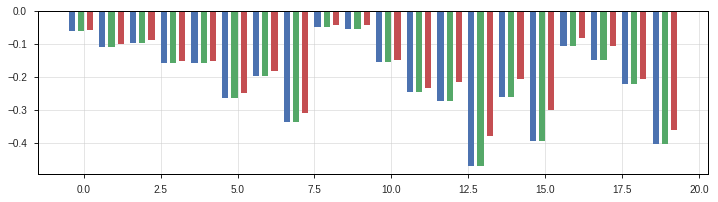

In [48]:
fig = plt.figure(figsize = (12,3))
ax1 = fig.add_subplot(111)
barX = np.arange(0,20)
offset = -0.4
for j in range(3):
    ax1.bar(barX+offset, [easyCompare[i][j] for i in range(20)], width=0.2)
    offset+=0.3